In [5]:
!pip install pennylane
!pip install torch torchvision torchaudio

  Using cached PennyLane-0.37.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.5 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
%matplotlib inline
from torchvision.datasets import MNIST

In [25]:
# Define paths
drive_path = '/content/drive/MyDrive/qgan_dataset'
os.makedirs(drive_path, exist_ok=True)

def preprocess_and_save_mnist(drive_path, image_size=16):
    # Define the transform to resize images
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    # Load MNIST dataset
    dataset = MNIST(root='/content', train=True, download=True, transform=transform)

    # Filter out only '0' digit images
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    for i, (image, label) in enumerate(data_loader):
        if label.item() == 0:
            # Convert tensor to PIL Image
            image = transforms.ToPILImage()(image.squeeze(0))
            # Save the image
            image_path = os.path.join(drive_path, f'digit_0_{i}.png')
            image.save(image_path)
    print('Finished saving all digit 0 images.')
# Run the function
preprocess_and_save_mnist(drive_path)

Finished saving all digit 0 images.


In [26]:
#I take randomly any 10 images of 0 from the folder created a new folder "qgan"

In [27]:
seed = 50
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [28]:
def getdata(path, label=0, transform=None):
  data = torch.tensor([])
  file_list = os.listdir(path)
  for file_name in file_list[:10]:
    image_path = os.path.join(path, file_name)
    image = mpimg.imread(image_path)
    image = image/255.0
    image=np.array(image)
    image = image.astype(np.float32).reshape(16, 16)
    if transform:
      image=self.transform(image)
    imageData = torch.from_numpy(image).float()
    data = torch.cat((data, imageData.unsqueeze(0)), dim=0)
  return data

file_path = '/content/drive/My Drive/qgan'
data_set=getdata(file_path)

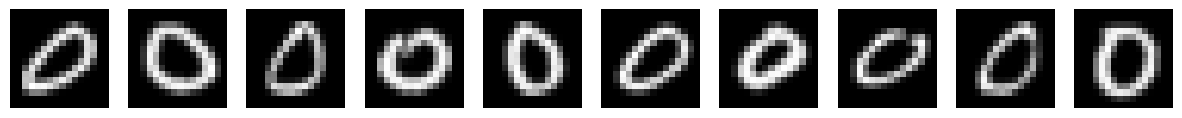

In [29]:
import matplotlib.pyplot as plt
num_images = 10
image_size = 16
batch_size = 1

# Create a grid of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in a subplot
for i in range(num_images):
    image = data_set[i]  # Get the image tensor
    image = image.squeeze().numpy()  # Remove singleton dimensions and convert to numpy array
    axes[i].imshow(image, cmap='gray')  # Display the image with proper scaling
    axes[i].axis('off')  # Hide the axis

# Show the plot
plt.show()

In [30]:
dataloader = torch.utils.data.DataLoader(
    data_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [31]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model=nn.Sequential(
        nn.Linear(image_size*image_size,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.model(x)

In [40]:
n_qubits =7
n_a_qubits=1
q_depth=6
n_generators=4

In [41]:
dev=qml.device("lightning.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):

  weights = weights.reshape(q_depth, n_qubits)

  for i in range(n_qubits):
    qml.RY(noise[i], wires=i)

  for i in range(q_depth):
    for y in range(n_qubits):
      qml.RY(weights[i][y], wires=y)

    for y in range(n_qubits-1):
      qml.CZ(wires=[y, y+1])

  return qml.probs(wires=list(range(n_qubits)))


def partial_measure(noise, weights):
  probs = quantum_circuit(noise, weights)
  probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
  probsgiven0 /= torch.sum(probs)

  probsgiven = probsgiven0/torch.max(probsgiven0)
  return probsgiven

In [43]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [54]:
lrG = 0.08 # Learning rate for the generator
lrD = 0.05  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [55]:

# Initialize models
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

# Labels for training
real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise for generating images
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Training loop
counter = 0
results = []

while counter < num_iter:
    for i, data in enumerate(dataloader):
        data = data.view(-1, image_size * image_size).to(device)
        real_data = data

        # Generate fake data
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the Discriminator
        discriminator.zero_grad()
        real_out = discriminator(real_data).view(-1)
        fake_out = discriminator(fake_data.detach()).view(-1)  # Detach fake_data to prevent gradients from flowing into the generator

        errD_real = criterion(real_out, real_labels)
        errD_fake = criterion(fake_out, fake_labels)
        errD = errD_real + errD_fake

        errD.backward()
        optD.step()

        # Training the Generator
        generator.zero_grad()
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2  # Regenerate noise
        fake_data = generator(noise)
        fake_out = discriminator(fake_data).view(-1)

        errG = criterion(fake_out, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD.item():0.3f}, Generator Loss: {errG.item():0.3f}')

            # Generate test images
            test_images = generator(fixed_noise).cpu().detach()

            # Print shape of test images
            print(f'Test images shape: {test_images.shape}')

            # Reshape and store images
            if test_images.shape[1] == image_size * image_size:
                test_images = test_images.view(-1, 1, image_size, image_size)  # Adjust according to batch size
            else:
                print("Unexpected output shape from generator.")
                continue

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter >= num_iter:
            break
    if counter >= num_iter:
        break


Iteration: 10, Discriminator Loss: 1.384, Generator Loss: 0.701
Test images shape: torch.Size([8, 256])
Iteration: 20, Discriminator Loss: 1.382, Generator Loss: 0.701
Test images shape: torch.Size([8, 256])
Iteration: 30, Discriminator Loss: 1.385, Generator Loss: 0.698
Test images shape: torch.Size([8, 256])
Iteration: 40, Discriminator Loss: 1.376, Generator Loss: 0.697
Test images shape: torch.Size([8, 256])
Iteration: 50, Discriminator Loss: 1.389, Generator Loss: 0.704
Test images shape: torch.Size([8, 256])
Iteration: 60, Discriminator Loss: 1.383, Generator Loss: 0.703
Test images shape: torch.Size([8, 256])
Iteration: 70, Discriminator Loss: 1.389, Generator Loss: 0.715
Test images shape: torch.Size([8, 256])
Iteration: 80, Discriminator Loss: 1.389, Generator Loss: 0.702
Test images shape: torch.Size([8, 256])
Iteration: 90, Discriminator Loss: 1.382, Generator Loss: 0.698
Test images shape: torch.Size([8, 256])
Iteration: 100, Discriminator Loss: 1.387, Generator Loss: 0.702

KeyboardInterrupt: 

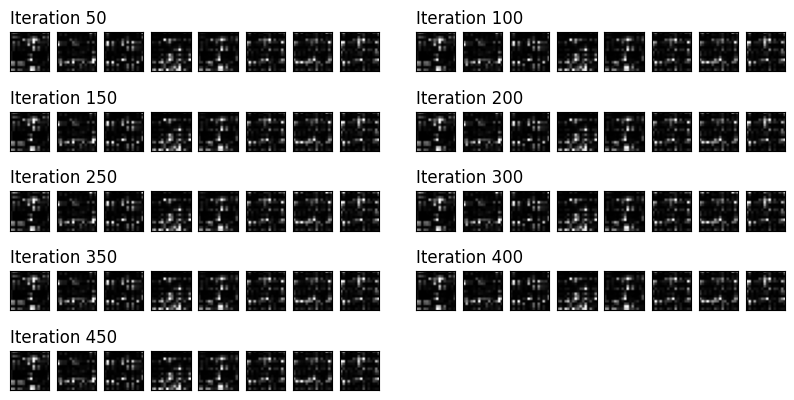

In [56]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()